**2장 – 머신러닝 프로젝트 처음부터 끝까지**

*머신러닝 부동산 회사에 오신 것을 환영합니다! 여러분이 할 작업은 캘리포니아 지역 주택의 여러 특성을 사용해 중간 가격을 예측하는 것입니다.*

*이 노트북은 2장의 모든 샘플 코드와 연습 문제 정답을 담고 있습니다.*

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수  테스트
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 데이터 가져오기

## 데이터 다운로드하기

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
#판다스로 데이터 읽기

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    
#모든 데이터를 담은 판다스 데이터프레임 객체 반환

## 데이터 구조 훑어 보기

In [5]:
housing_181136 = load_housing_data()
housing_181136.head()

# 처음 다섯행
# 각 행이 하나의 구역
#10개의 특성


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing_181136.info()
# 데이터에 대한 설명, 전체행의 수, 각 특성의 데이터 타입, 널이 아닌갯수

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing_181136["ocean_proximity"].value_counts()
# 카테고리 종류와 카테고리당 구역(행)의 수

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing_181136.describe()
# 숫자형 특성의 요약정보
# 25%,50%,75% : 백위분에 속하는 하위부분의 값. 25%: housing_median_age가 18보다 작다, 50%: 29보다 작다

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


그림 저장: attribute_histogram_plots


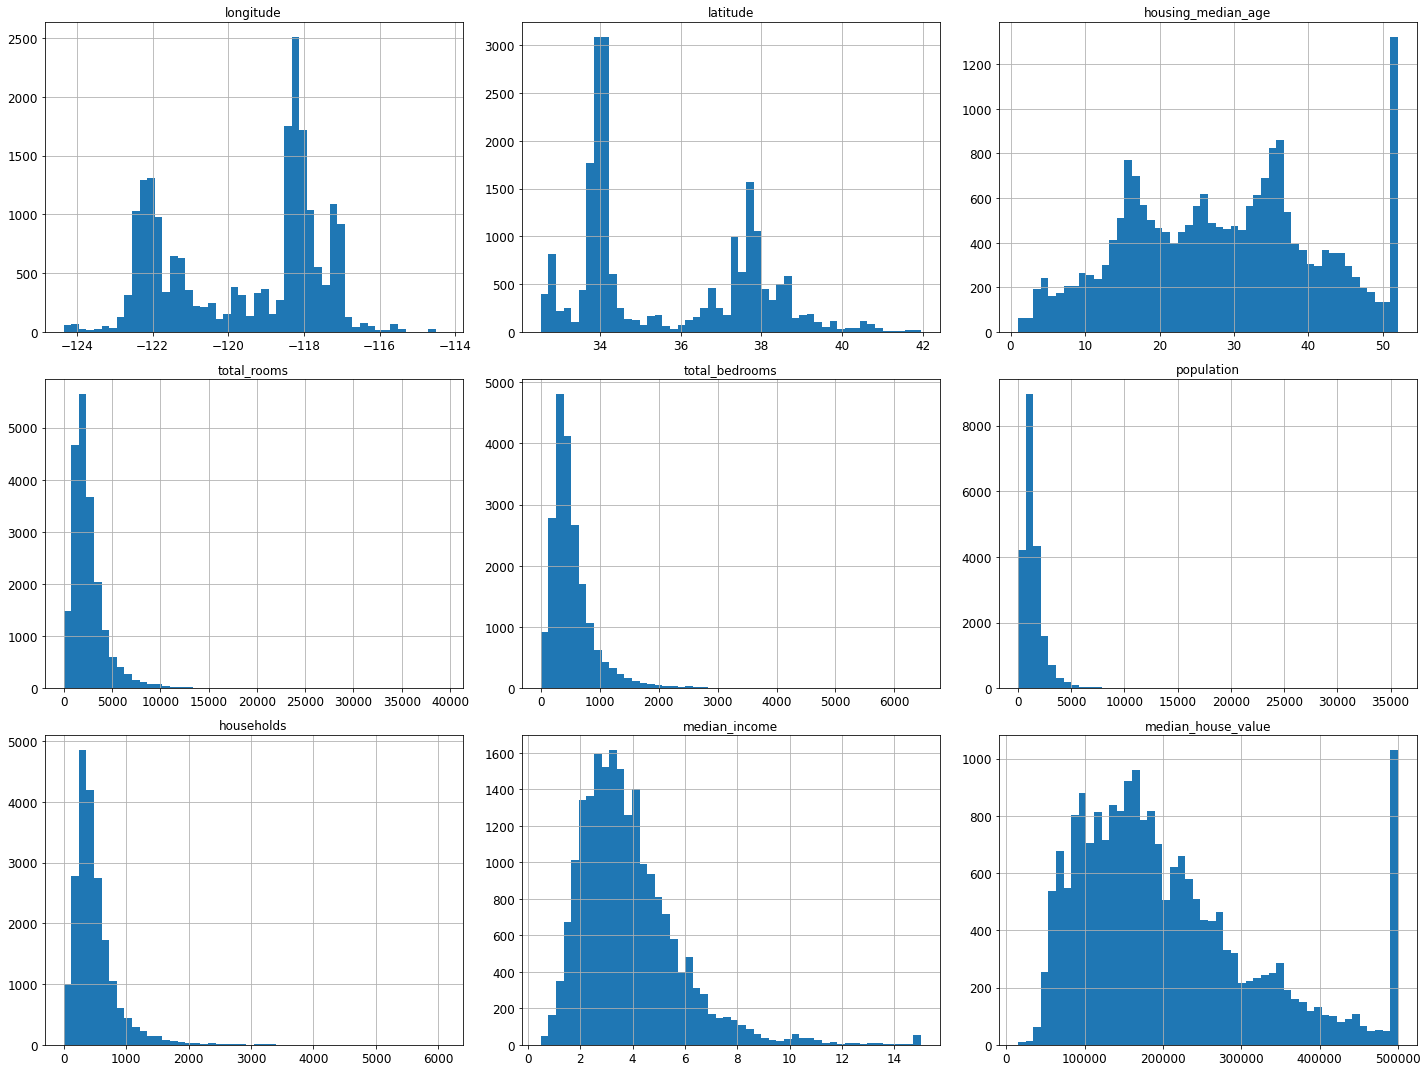

In [9]:
# 숫자형 특성에 대한 히스토그램, 주어진 값의 범위(x)에 속한 샘플수(y)

%matplotlib inline

# 그래프를 노트북안에 그리기

import matplotlib.pyplot as plt
housing_181136.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# median_income : 상한 15, 하한 0.5 (3은 3만 달러)
# housing_median age, median_house_value: 최대값, 최소값 한정
# 레이블인 median_house_value의 상한값(최대값)이 있어서 예측도 이값을 넘지 않는다.
# 해결 1. 한계값 밖의 정확한 값 알아내기
# 해결 2. 훈련세트/테스트세트에서 제거
# 전체적으로 특성들의 스케일이 다름
# 특성들의 히스토그램 꼬리가 길다(오른쪽): 패턴찾기가 어려워 분포 조정
# 테스트세트 들여다 보지 않기

## 테스트 세트 만들기

In [10]:
# 노트북의 실행 결과가 동일하도록
# skip
np.random.seed(42)

In [11]:
import numpy as np

# skip
# 예시로 만든 것입니다. 실전에서는 사이킷런의 train_test_split()를 사용하세요.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
# skip
train_set, test_set = split_train_test(housing_181136, 0.2)
len(train_set)

16512

In [13]:
# skip
len(test_set)

4128

In [14]:
# skip
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

위의 `test_set_check()` 함수가 파이썬 2와 파이썬 3에서 모두 잘 동작합니다. 초판에서는 모든 해시 함수를 지원하는 다음 방식을 제안했지만 느리고 파이썬 2를 지원하지 않습니다.

In [15]:
# skip
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

모든 해시 함수를 지원하고 파이썬 2와 파이썬 3에서 사용할 수 있는 함수를 원한다면 다음을 사용하세요.

In [16]:
# skip
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [17]:
# skip
housing_with_id = housing_181136.reset_index()   # `index` 열이 추가된 데이터프레임을 반환합니다
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [18]:
# skip
housing_with_id["id"] = housing_181136["longitude"] * 1000 + housing_181136["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [19]:
# skip
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [20]:
# 무작위 샘플링에 의한 훈련/테스트 분할
# 난수 초기값 지정
# 20%의 테스트, 80%의 훈련
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_181136, test_size=0.2, random_state=42)

In [21]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<AxesSubplot:>

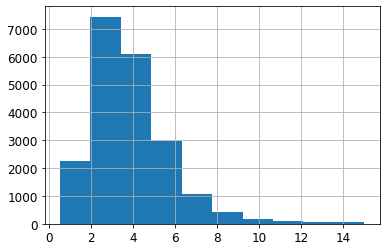

In [22]:
# 계층적 샘플링
# 중간소득(median_income)이 중간주택가격을 예측하는데 매우중요(전문가의견)
# 중간소득의 카테고리빈도에 따라 훈련/테스트세트를 구성
# 중간소득이 1.5~6 사이에 모여있음
# 계층별로 충분한 샘플수 필요, 너무 많은 계층으로 나누면 안됨

housing_181136["median_income"].hist()

In [23]:
# pd.cut으로 5개의 카테고리 생성
# 1~5까지 레이블

housing_181136["income_cat"] = pd.cut(housing_181136["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [24]:
#카테고리별 빈도수

housing_181136["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

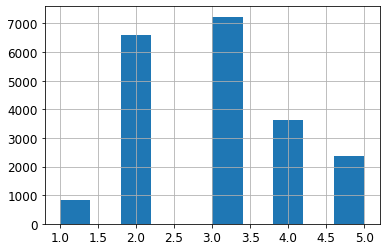

In [25]:
# x축 : 1~5 레이블
housing_181136["income_cat"].hist()

In [26]:
#stratifiedshfflesplit

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_181136, housing_181136["income_cat"]):
    strat_train_set = housing_181136.loc[train_index]
    strat_test_set = housing_181136.loc[test_index]

In [27]:
# 소득카테고리의 비율

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [28]:
# 전체데이터에서 카테고리별 빈도수

housing_181136["income_cat"].value_counts() / len(housing_181136)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [29]:
# skip
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing_181136, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing_181136),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [30]:
# skip
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [31]:
# income_cat 삭제 (원래 상태로 만들기)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 데이터 이해를 위한 탐색과 시각화

In [32]:
# 훈련세트 보호를 위해 복사

housing_181136 = strat_train_set.copy()

## 지리적 데이터 시각화

그림 저장: bad_visualization_plot


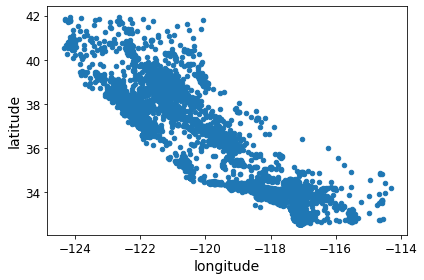

In [33]:
# 지리정보(위도/경도)산점도로 시각화

housing_181136.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

그림 저장: better_visualization_plot


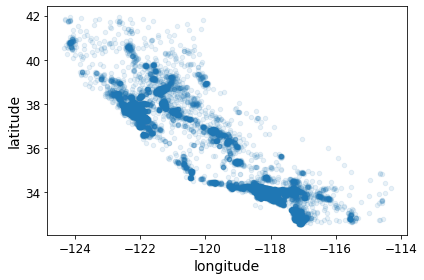

In [34]:
# alpha옵션으로 밀집정도를 투명도로 나타냄
# 베이 지역, 로스앤젤리스 근처, 샌디에고 부분이 밀집

housing_181136.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

`sharex=False` 매개변수는 x-축의 값과 범례를 표시하지 못하는 버그를 수정합니다. 이는 임시 방편입니다(https://github.com/pandas-dev/pandas/issues/10611 참조). 수정 사항을 알려준 Wilmer Arellano에게 감사합니다.

그림 저장: housing_prices_scatterplot


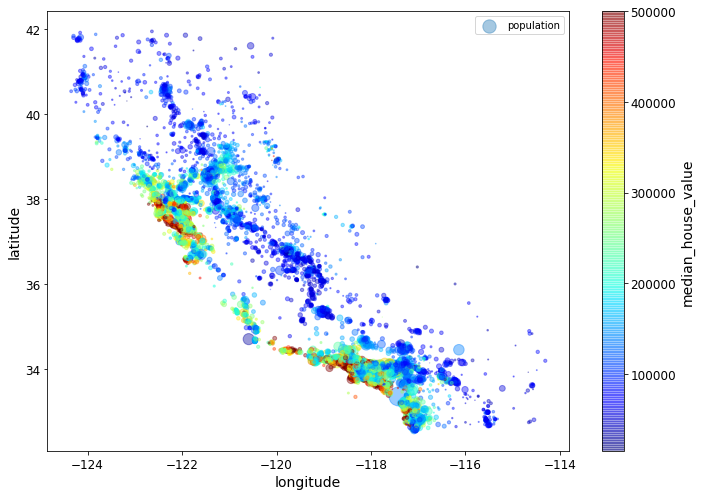

In [35]:
# 주택 가격 시각화
# 원의 반지름 : 구역의 인구(s), 색상(c): 가격
# 컬러맵(cmap) : jet(빨간색-높은가격, 파란색-낮은가격)
# 해안가 부분이 붉은색
# 북쪽은 패턴에서 벗어나 있음
housing_181136.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing_181136["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [36]:
#캘리포니아 이미지와 겹쳐보기

# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x1f48298e6a0>)

그림 저장: california_housing_prices_plot


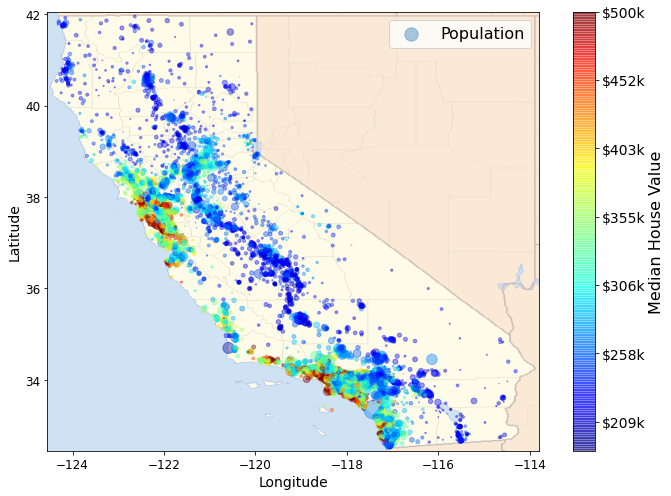

In [37]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing_181136.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing_181136['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing_181136["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

## 상관관계 조사

In [38]:
#표준상관계수(피어슨 상관계수)

corr_matrix = housing_181136.corr()

In [39]:
# 중간주택 가격과 다른 특성 사이의 상관관계 크기
# 상관 관계 범위 -1 ~ 1
# 1에 가까우면 강한 양의 상관관계, 한쪽이 올라가면 같이 증가
# -에 가까우면 음의 상관관계, 위도(latitude)와 중간주택사이 약한 상관관계

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

피어슨의 상관 계수(위키백과):
![Pearson correlation coefficient](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

피어슨 상관계수는 선형적인 관계만 파악
x가 0에 가까울수록 값이 y가 증가하는경우 파악 어려움


그림 저장: scatter_matrix_plot


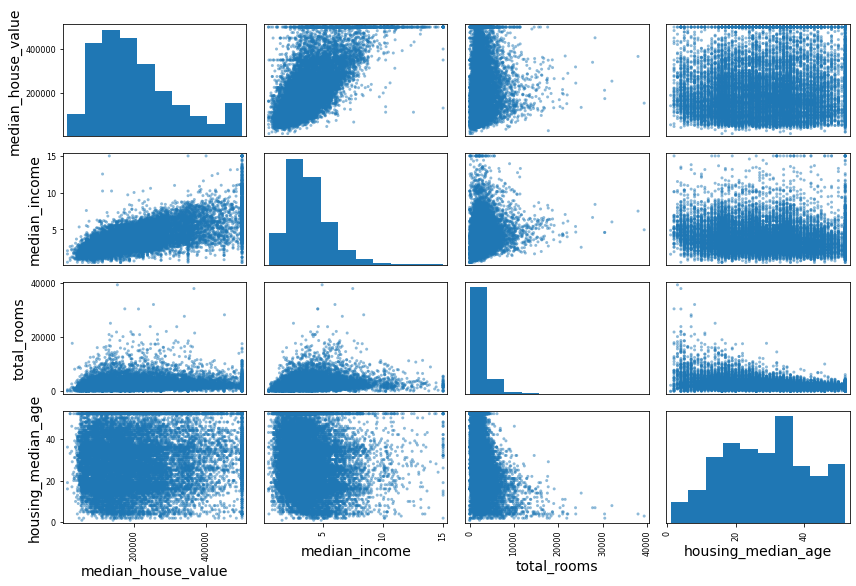

In [40]:
# 두 값사이의 관계를 산점도로 파악
# 숫자형 특성사이의 산점도 그리기 : scatter_matrix
# 중간주택가격과 관계가 있는 몇개의 특성 살펴보기
# 대각선은 자신에 대한 히스토그램


# from pandas.tools.plotting import scatter_matrix # 옛날 버전의 판다스에서는
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing_181136[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

그림 저장: income_vs_house_value_scatterplot


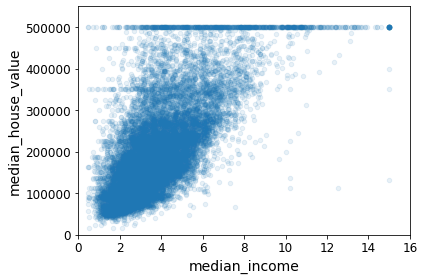

In [41]:
# median_income vs. median_house_value
# 상관관계가 비교적 강하다. 위로 향하는 경향, 포인터들이 비교적 모여있다, 
# $500,000, $450,000, $350000, $280,000 수평선이 있음, 데이터 전처리 고민(삭제?)

housing_181136.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

## 특성 조합으로 실험

In [42]:
# 가구수 대비 방의 갯수 : rooms_per_household
# 전체방의 수 대비 침실수 :bedrooms_per_room
# 가구수 대비 인구수 : population_per_household

housing_181136["rooms_per_household"] = housing_181136["total_rooms"]/housing_181136["households"]
housing_181136["bedrooms_per_room"] = housing_181136["total_bedrooms"]/housing_181136["total_rooms"]
housing_181136["population_per_household"]=housing_181136["population"]/housing_181136["households"]

In [43]:
# 새로운 특성으로 상관관계 분석
# bedrooms_per_room(-0.26) 가 total_rooms(0.13), total_bedrooms(0.048) 보다 상관관계가 높음
# 침실/방의 비율("total_bedrooms"/"total_rooms")이 낮으면 더 집값이 비싸다
# rooms_per_household(0.146255)가 total_rooms(0.135)보다 높음


corr_matrix = housing_181136.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

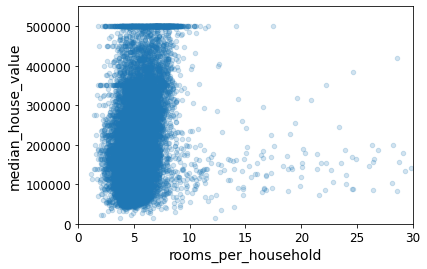

In [44]:
#housing.plot(kind="scatter", x="median_income", y="median_house_value",
             #alpha=0.1)
housing_181136.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 30, 0, 550000])
plt.show()

In [45]:
housing_181136.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


슬라이드 살펴보기

# 머신러닝 알고리즘을 위한 데이터 준비

In [46]:
# axis = 1 : 열

housing_181136 = strat_train_set.drop("median_house_value", axis=1) # 훈련 세트를 위해 레이블 삭제
housing_labels = strat_train_set["median_house_value"].copy()

## 데이터 정제

책에 소개된 세 개의 옵션은 다음과 같습니다:

```
housing.dropna(subset=["total_bedrooms"])    # 옵션 1
housing.drop("total_bedrooms", axis=1)       # 옵션 2
median = housing["total_bedrooms"].median()  # 옵션 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

각 옵션을 설명하기 위해 주택 데이터셋의 복사본을 만듭니다. 이 때 적어도 하나의 열이 비어 있는 행만 고릅니다. 이렇게 하면 각 옵션의 정확한 동작을 눈으로 쉽게 확인할 수 있습니다.

In [47]:
# isnull()을 이용하여 null인 항목 살펴보기
# NaN : Not a Number

sample_incomplete_rows = housing_181136[housing_181136.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [48]:
# dropna : na not available
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [49]:
#axis = 1 : 컬럼(열,특성) 삭제

sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [50]:
# 훈련데이터의 미디언값을 구해서 따로 저장 (테스트 데이터 사용하면 안됨)
# fillna 로 중간값 채우기

median = housing_181136["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [51]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [52]:
# SimpleImputer 사용 : median 으로 채우기
# KNNImputer 

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 삭제합니다:

In [53]:
housing_num = housing_181136.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [54]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [55]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인해 보세요:

In [56]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

훈련 세트를 변환합니다:

In [57]:
X = imputer.transform(housing_num)
# 넘파이 배열

In [58]:
# 판다스 데이터프레임으로 변환

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [59]:
# skip

housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [60]:
# skip

imputer.strategy

'median'

In [61]:
# skip

housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## 텍스트와 범주형 특성 다루기

이제 범주형 입력 특성인 `ocean_proximity`을 전처리합니다:

In [62]:
housing_cat = housing_181136[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [63]:
# text를 숫자로 변환
# 순서가 있고 값으로 비교 가능하다. bad, average, good, excellent. 교재 예제에는 맞지 않음, 

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [64]:
# 카테고리 목록보기
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [65]:
# OneHotEncoding : 한 특성만 1이고 나머지는 0

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

# sparse 행렬로 저장 : 0이 아닌 위치만 저장

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

`OneHotEncoder`는 기본적으로 희소 행렬을 반환합니다. 필요하면 `toarray()` 메서드를 사용해 밀집 배열로 변환할 수 있습니다:

In [66]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

또는 `OneHotEncoder`를 만들 때 `sparse=False`로 지정할 수 있습니다:

In [67]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [68]:
# 카테고리 리스트 보기

cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## 나만의 변환기(파이프라인)

추가 특성을 위해 사용자 정의 변환기를 만들어보죠:

In [69]:
# skip

from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_181136.to_numpy())

책에서는 간단하게 인덱스 (3, 4, 5, 6)을 하드코딩했지만 다음처럼 동적으로 처리하는 것이 더 좋습니다:

In [70]:
# skip

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing_181136.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

또한 `housing_extra_attribs`는 넘파이 배열이기 때문에 열 이름이 없습니다(안타깝지만 사이킷런을 사용할 때 생기는 문제입니다). `DataFrame`으로 복원하려면 다음과 같이 할 수 있습니다:

In [71]:
# skip

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing_181136.columns)+["rooms_per_household", "population_per_household"],
    index=housing_181136.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29,3873,797,2237,706,2.1736,INLAND,5.48584,3.16856
15502,-117.23,33.09,7,5320,855,2015,768,6.3373,NEAR OCEAN,6.92708,2.6237
2908,-119.04,35.37,44,1618,310,667,300,2.875,INLAND,5.39333,2.22333
14053,-117.13,32.75,24,1877,519,898,483,2.2264,NEAR OCEAN,3.88613,1.85921
20496,-118.7,34.28,27,3536,646,1837,580,4.4964,<1H OCEAN,6.09655,3.16724


2022.03.16

## 변환 파이프라인

수치형 특성을 전처리하기 위해 파이프라인을 만듭니다:

In [72]:
# 파이프라인 : 연속된 단계를 나타냄
# 이름/추정기쌍으로 목록입력

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [73]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [74]:
#하나의 변환기로 각 열마다 다른 변환 적용

from sklearn.compose import ColumnTransformer

# 수치형 열이름 리스트
num_attribs = list(housing_num)

# 범주형 열이름 리스트
cat_attribs = ["ocean_proximity"]

# ColumnTransformer 객체 리스트
# 이름, 변환기, 변환기 적용될 열 이름(인덱스)
# num_pipeline은 위에서 정의

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# num_pipeline은 밀집행렬, OneHotEncoder()은 희소행렬
# ColumnTransformer이 밀집도( 0이 아닌 원소의 비율)가 임계값보다 낮으면 희소행렬 반환
# 밀집도가 있어서 밀집행렬 반환


# 파이프라인을 housing 데이터에 적용
housing_prepared = full_pipeline.fit_transform(housing_181136)

In [75]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [76]:
housing_prepared.shape

(16512, 16)

다음은 (판다스 `DataFrame` 열의 일부를 선택하기 위해) `DataFrameSelector` 변환기와 `FeatureUnion`를 사용한 예전 방식입니다:

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

하나의 큰 파이프라인에 이들을 모두 결합하여 수치형과 범주형 특성을 전처리합니다:

In [78]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [79]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [80]:
old_housing_prepared = old_full_pipeline.fit_transform(housing_181136)
old_housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

`ColumnTransformer`의 결과와 동일합니다:

In [81]:
np.allclose(housing_prepared, old_housing_prepared)

True

슬라이드 살펴보기

# 모델 선택과 훈련

## 훈련 세트에서 훈련하고 평가하기

In [82]:
# 선형회귀모델

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [83]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용해 보겠습니다
some_data = housing_181136.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


실제 값과 비교합니다:

In [84]:
print("레이블:", list(some_labels))

레이블: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [85]:
some_data_prepared

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.01802432, -0.07537122,
        -0.33827252,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.59513997, -0.10680295,
         0.96120521,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.43743108, -0.63581817, -0

In [86]:
# RMSE 평가


from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# 중간 주택 가격이 $120,000에서 $265,000 사이 분포
# 예측 오차 68627 : 좋은결과??? -> 과소적합
# 문제점 : 특성들이 좋은 정보를 제공하기 못했거나 모델이 강력하지 못하다
# 해결 : 좋은 특성 주입(찾거나 생성), 모델의 규제 감소
# 선형모델에서는 규제 감소 여지가 없음
# 특성 추가 ( 인구의 로그스케일)
# 다른 모델 시도


68627.87390018745

**노트**: 사이킷런 0.22 버전부터는 `squared=False` 매개변수로 `mean_squared_error()` 함수를 호출하면 RMSE를 바로 얻을 수 있습니다.

In [87]:
# MAE 계산

from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49438.66860915801

In [88]:
# 결정트리

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [89]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# 오차가 0
# 훈련데이터에 과적합

0.0

슬라이드 살펴보기

## 교차 검증을 사용한 평가

In [90]:
# cv=10 : 10개의 서브셋으로 무작위 분할
# 10번 평가, 매번 다른 1개를 평가, 나머지 9개를 훈련
# 10개의 결과 생성

# 결정트리 교차검증

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# 교차검증에서 scoring을 효용함수(클수록 좋은값)로 계산해서 neg_mean_squared_error
# np.sqrt(-scores)

In [91]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

# 이전보다 오차가 있음
# 각 훈련의 평균과 표준편차를 통해 모델의 성능과 추정이 얼마나 정확한지 측정
# 반복된 훈련으로 훈련 비용이 비싸다

점수: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
평균: 71629.89009727491
표준 편차: 2914.035468468928


In [92]:
# 선형회귀 교차검증

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균: 69104.07998247063
표준 편차: 2880.3282098180675


**노트**: 사이킷런 0.22 버전에서 `n_estimators`의 기본값이 100으로 바뀌기 때문에 향후를 위해 `n_estimators=100`로 지정합니다(책에는 등장하지 않습니다).

In [93]:
# 랜덤포레스트 : 특성을 무작위로 선택해서 다수의 결정트리 생성
# 예측을 평균, 앙상블 방법
# 100개의 트리 생성

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [94]:
#랜덤포레스트 RMSE 계산

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [95]:
# 랜덤포레스트 교차검증 cv =10

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
평균: 50435.58092066179
표준 편차: 2203.3381412764606


In [96]:
# 선형회귀 결과 describe()로 살펴보기

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69104.079982
std       3036.132517
min      64114.991664
25%      67077.398482
50%      68718.763507
75%      71357.022543
max      73997.080502
dtype: float64

In [97]:
#랜덤포레스트 결과 describe()로 살펴보기

scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     50435.580921
std       2322.522327
min      47210.512698
25%      48682.893887
50%      50812.405036
75%      51872.228024
max      54055.908946
dtype: float64

In [98]:
#서포트벡터머신 적용하기

from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291966

In [99]:
# SVM 교차 검증

from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

점수: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 113168.96643781 111945.40954593]
평균: 111814.1069260169
표준 편차: 2600.840269089257


In [100]:
# describe() 결과보기

scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count        10.000000
mean     111814.106926
std        2741.526360
min      106998.562270
25%      110848.005913
50%      112450.979115
75%      113251.558304
max      116063.778167
dtype: float64

In [101]:
# 각 모델별 RMSE 출력

print("선형회귀:", lin_rmse_scores.mean())
print("결정트리:", tree_rmse_scores.mean())
print("랜덤포레스트:", forest_rmse_scores.mean())
print("SVM:", svm_rmse_scores.mean())


선형회귀: 69104.07998247063
결정트리: 71629.89009727491
랜덤포레스트: 50435.58092066179
SVM: 111814.1069260169


슬라이드 살펴보기

# 모델 세부 튜닝

## 그리드 탐색(GridSearchCV)

In [102]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# n_estimators : 결정트리 갯수
# max_features : feature 수

#  {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]} : 딕셔너리
# 3 일때 2,4,6,8 조합 실행

# 총 12+6 = 18번의 조합 탐색. 


# 랜덤포레스트로 그리드탐색

forest_reg = RandomForestRegressor(random_state=42)

# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

최상의 파라미터 조합은 다음과 같습니다:

In [103]:
#최상의 조합보기

grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [104]:
#최적의 추정기 보기

grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [105]:
# 파라미터 살펴보기
grid_search.cv_results_["params"]

[{'max_features': 2, 'n_estimators': 3},
 {'max_features': 2, 'n_estimators': 10},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 4, 'n_estimators': 3},
 {'max_features': 4, 'n_estimators': 10},
 {'max_features': 4, 'n_estimators': 30},
 {'max_features': 6, 'n_estimators': 3},
 {'max_features': 6, 'n_estimators': 10},
 {'max_features': 6, 'n_estimators': 30},
 {'max_features': 8, 'n_estimators': 3},
 {'max_features': 8, 'n_estimators': 10},
 {'max_features': 8, 'n_estimators': 30},
 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3},
 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10},
 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3},
 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10},
 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3},
 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}]

In [106]:
# 스코어보기
score=grid_search.cv_results_["mean_test_score"]
print(np.sqrt(-score))

[63895.16157795 54916.3238635  52885.86715332 60075.368033
 52495.01284985 50187.24324927 58064.73529982 51519.32062366
 49969.80441628 58895.82499816 52459.79624725 49898.98913455
 62381.76510692 54476.57050944 59974.60028085 52754.56328132
 57831.13606121 51278.3787714 ]


그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다:

In [107]:
#점수와 파라미터

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# 'max_features': 8, 'n_estimators': 30 일때 RMSE가 가장 낮다. 
# 이전의 CV 보다 좋은 결과 탐색

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [108]:
#데이터프레임으로 테이블뷰로 보기

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.066025,0.004935,0.003572,0.000514,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.216929,0.019800,0.010262,0.001076,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.640403,0.052349,0.028737,0.002394,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.108543,0.008408,0.004142,0.000711,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.321740,0.008514,0.009753,0.000617,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,0.978603,0.008448,0.026936,0.001179,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.135604,0.006795,0.003211,0.000210,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.441439,0.016144,0.010634,0.000357,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,1.355173,0.028834,0.026671,0.002116,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.167534,0.005988,0.003595,0.000509,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


 랜덤 탐색(RandomizedSearchCV)

In [109]:
# 랜덤하게 탐색공간을 탐색
# 탐색공간이 클 경우 그리드서치보다 추천
# 설정값이 연속형일 경우 추천
# 사이파이의 randint를 이용하여 범위내의 정수값을 균등분포로 추출 

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

# 탐색 반복수n_iter=10

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4FF0E2580>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4FEC19730>},
                   random_state=42, scoring='neg_mean_squared_error')

In [110]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


## 최상의 모델과 오차 분석

In [111]:
# 특성 중요도 보기

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [112]:
# 새로 추가한 특성

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # 예전 방식

# named_transformers : 파이프라인에서 특정 특징 참조
# cat : 범주형 특성을 원핫인코더로 변경하는 클래스 

cat_encoder = full_pipeline.named_transformers_["cat"]

# 원핫인코딩의 카테고리의 특성 추출
# ocien_proximity

cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs

# sort 하여 특징의 중요도 보여주기

sorted(zip(feature_importances, attributes), reverse=True)

# median_income, inland, pop_per_hhold 등이 좋은 특징
# 범주형 값이 좋은 결과를 보여주지 못해 삭제 가능

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204355, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887772, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

## 테스트 세트로 시스템 평가하기

In [113]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# 훈련세트가 아니므로 fit_transform 이 아니라 transform 사용
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

# 테스트 데이터에 적용한 값이 더 낮은 경우가 일반적
# 테스트 데이터를 위해서 다시 하이퍼 파라미터 조정은 바람직하지 않음

In [114]:
final_rmse

47873.26095812988

테스트 RMSE에 대한 95% 신뢰 구간을 계산할 수 있습니다:

In [115]:
from scipy import stats

confidence = 0.95

# 모든 샘플에 대한 제곱오차
squared_errors = (final_predictions - y_test) ** 2

# final_predictions 넘파이배열, y_test : 시리즈(판다스데이터프레임) -> 결과는 시리즈
# squared_errors 샘플갯수

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(), #평균값
                         scale=stats.sem(squared_errors))) # 표준오차 계산

# 신뢰구간

array([45893.36082829, 49774.46796717])

다음과 같이 수동으로 계산할 수도 있습니다:

In [116]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
# delta degree of freedom, 기본값이 다를수 있으므로 명시적으로 표시
# numpy.std(ddof=0)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m) 
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45893.3608282853, 49774.46796717339)

또는 t-점수 대신 z-점수를 사용할 수도 있습니다:

In [117]:
zscore = stats.norm.ppf((1 + confidence) / 2)

# squared_errors.std(ddof=1) / np.sqrt(m) : 표준오차

zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45893.954011012866, 49773.92103065016)

# 추가 내용

## 전처리와 예측을 포함한 전체 파이프라인

In [118]:
#전체 프로세스를 하나의 파이프라인으로 

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing_181136, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])

## joblib를 사용한 모델 저장

In [119]:
# 모델을 저장하기위해 사용

my_model = full_pipeline_with_predictor

In [120]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## `RandomizedSearchCV`를 위한 Scipy 분포 함수

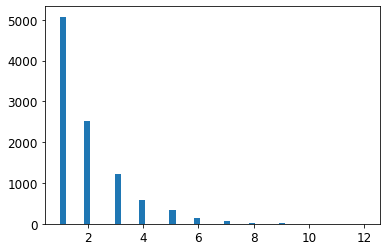

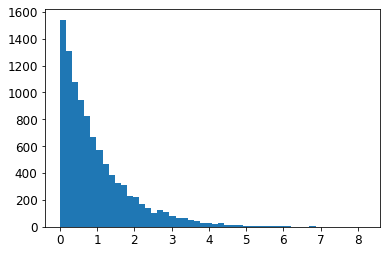

In [121]:
# randint 대신 다른 분포

from scipy.stats import geom, expon

# 기하분포 확률이 0.5, 10000개 추출
# 이산적

geom_distrib=geom(0.5).rvs(10000, random_state=42)

# 지수분포 : 스케일 1 (1/람다), 10000개 추출
# 연속적 
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# 연습문제 해답

## 1.

질문: 서포트 벡터 머신 회귀(`sklearn.svm.SVR`)를 `kernel=“linear”`(하이퍼파라미터 `C`를 바꿔가며)나 `kernel=“rbf”`(하이퍼파라미터 `C`와 `gamma`를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 지금은 이 하이퍼파라미터가 무엇을 의미하는지 너무 신경 쓰지 마세요. 최상의 `SVR` 모델은 무엇인가요?
**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 30분 또는 그 이상 걸릴 수 있습니다.


{'C': 30000.0, 'kernel': 'linear'}

In [122]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=  10.5s
[CV] END ..............................C=10.0, kernel=linear; total time=   9.8s
[CV] END ..............................C=10.0, kernel=linear; total time=   9.6s
[CV] END ..............................C=10.0, kernel=linear; total time=   9.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.8s
[CV] END ..............................C=30.0, kernel=linear; total time=   9.2s
[CV] END ..............................C=30.0, kernel=linear; total time=   9.2s
[CV] END ..............................C=30.0, kernel=linear; total time=  10.3s
[CV] END ..............................C=30.0, kernel=linear; total time=   8.9s
[CV] END ..............................C=30.0, kernel=linear; total time=   9.1s
[CV] END .............................C=100.0, kernel=linear; total time=   8.9s
[CV] END .............................C=100.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [123]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70286.61836440137

`RandomForestRegressor`보다 훨씬 좋지 않네요. 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [124]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

선형 커널이 RBF 커널보다 성능이 나은 것 같습니다. `C`는 테스트한 것 중에 최대값이 선택되었습니다. 따라서 (작은 값들은 지우고) 더 큰 값의 `C`로 그리드서치를 다시 실행해 보아야 합니다. 아마도 더 큰 값의 `C`에서 성능이 높아질 것입니다.

## 2.

질문: `GridSearchCV`를 `RandomizedSearchCV`로 바꿔보세요.

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 45분 또는 그 이상 걸릴 수 있습니다.

In [125]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# expon(), reciprocal()와 그외 다른 확률 분포 함수에 대해서는
# https://docs.scipy.org/doc/scipy/reference/stats.html를 참고하세요.

# 노트: kernel 매개변수가 "linear"일 때는 gamma가 무시됩니다.
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=  10.0s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   9.8s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   9.7s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=  10.8s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   9.7s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  18.7s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  18.8s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  19.0s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  19.0s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  19.1s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4FEE8BF70>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4FF7029A0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [126]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54751.69009256622

이제 `RandomForestRegressor`의 성능에 훨씬 가까워졌습니다(하지만 아직 차이가 납니다). 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [127]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

이번에는 RBF 커널에 대해 최적의 하이퍼파라미터 조합을 찾았습니다. 보통 랜덤서치가 같은 시간안에 그리드서치보다 더 좋은 하이퍼파라미터를 찾습니다.

여기서 사용된 `scale=1.0`인 지수 분포를 살펴보겠습니다. 일부 샘플은 1.0보다 아주 크거나 작습니다. 하지만 로그 분포를 보면 대부분의 값이 exp(-2)와 exp(+2), 즉 0.1과 7.4 사이에 집중되어 있음을 알 수 있습니다.

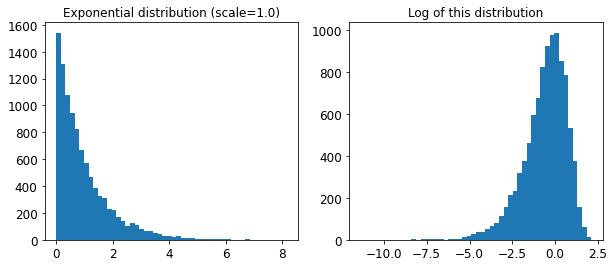

In [128]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`C`에 사용된 분포는 매우 다릅니다. 주어진 범위안에서 균등 분포로 샘플링됩니다. 그래서 오른쪽 로그 분포가 거의 일정하게 나타납니다. 이런 분포는 원하는 스케일이 정확이 무엇인지 모를 때 사용하면 좋습니다:

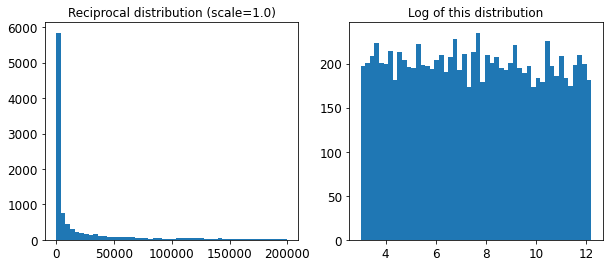

In [129]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`reciprocal()` 함수는 하이퍼파라미터의 스케일에 대해 전혀 감을 잡을 수 없을 때 사용합니다(오른쪽 그래프에서 볼 수 있듯이 주어진 범위안에서 모든 값이 균등합니다). 반면 지수 분포는 하이퍼파라미터의 스케일을 (어느정도) 알고 있을 때 사용하는 것이 좋습니다.

## 3.

질문: 가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보세요.

In [130]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

노트: 이 특성 선택 클래스는 이미 어떤 식으로든 특성 중요도를 계산했다고 가정합니다(가령 `RandomForestRegressor`을 사용하여). `TopFeatureSelector`의 `fit()` 메서드에서 직접 계산할 수도 있지만 (캐싱을 사용하지 않을 경우) 그리드서치나 랜덤서치의 모든 하이퍼파라미터 조합에 대해 계산이 일어나기 때문에 매우 느려집니다.

선택할 특성의 개수를 지정합니다:

In [131]:
k = 5

최상의 k개 특성의 인덱스를 확인해 보겠습니다:

In [132]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12], dtype=int64)

In [133]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

최상의 k개 특성이 맞는지 다시 확인합니다:

In [134]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204355, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude')]

좋습니다. 이제 이전에 정의한 준비 파이프라인과 특성 선택기를 추가한 새로운 파이프라인을 만듭니다:

In [135]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [137]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing_181136)

처음 3개 샘플의 특성을 확인해 보겠습니다:

In [138]:
housing_prepared_top_k_features[0:3]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

최상의 k개 특성이 맞는지 다시 확인합니다:

In [139]:
housing_prepared[0:3, top_k_feature_indices]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

성공입니다!  :)

## 4.

질문: 전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어보세요.

In [140]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [141]:
prepare_select_and_predict_pipeline.fit(housing_181136, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

몇 개의 샘플에 전체 파이프라인을 적용해 보겠습니다:

In [142]:
some_data = housing_181136.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 83384.49158095 299407.90439234  92272.03345144 150173.1619904 ]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


전체 파이프라인이 잘 작동하는 것 같습니다. 물론 예측 성능이 아주 좋지는 않습니다. `SVR`보다 `RandomForestRegressor`가 더 나은 것 같습니다.

## 5.

질문: `GridSearchCV`를 사용해 준비 단계의 옵션을 자동으로 탐색해보세요.

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 45분 또는 그 이상 걸릴 수 있습니다.

**노트**: 아래 코드에서 훈련 도중 경고를 피하기 위해 `OneHotEncoder`의 `handle_unknown` 하이퍼파라미터를 `'ignore'`로 지정했습니다. 그렇지 않으면 `OneHotEncoder`는 기본적으로 `handle_unkown='error'`를 사용하기 때문에 데이터를 변활할 때 훈련할 때 없던 범주가 있으면 에러를 냅니다. 기본값을 사용하면 훈련 세트에 모든 카테고리가 들어 있지 않은 폴드를 평가할 때 `GridSearchCV`가 에러를 일으킵니다. `'ISLAND'` 범주에는 샘플이 하나이기 때문에 일어날 가능성이 높습니다. 일부 폴드에서는 테스트 세트 안에 포함될 수 있습니다. 따라서 이런 폴드는 `GridSearchCV`에서 무시하여 피하는 것이 좋습니다.

In [144]:
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing_181136, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  10.2s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  16.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  19.7s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  19.4s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  16.9s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  11.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  16.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  17.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  16.7s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  16.8s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  11.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  17.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  16.7s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  18.8s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  19.8s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  14.6s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  21.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  20.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  22.3s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  22.5s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  14.2s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  20.2s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  19.7s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  19.9s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  22.1s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  13.9s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  20.7s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  20.7s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  20.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  19.9s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  14.4s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  20.3s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  20.7s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  20.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  19.8s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  14.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  17.7s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  21.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  20.8s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  21.1s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  14.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  20.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  20.0s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  20.7s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  20.3s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  15.0s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  21.4s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  22.2s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  21.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  19.7s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  14.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  17.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  17.5s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  17.3s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  17.5s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  12.1s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  17.5s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  17.5s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  17.4s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  17.5s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  12.6s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  18.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  17.7s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  19.4s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  18.4s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  12.6s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  18.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  18.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  17.9s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  18.6s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  12.7s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  18.3s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  18.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  18.3s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  18.2s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  12.8s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time= 2.7min
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time= 2.7min
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time= 2.7min
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time= 2.7min


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  13.2s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time= 2.4min
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time= 2.5min
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time= 2.6min
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time= 2.7min


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  13.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time= 2.7min
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time= 2.6min
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time= 2.6min
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time= 2.6min


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  13.4s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time= 2.7min
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time= 2.7min
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time= 2.7min
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time= 2.7min


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  13.7s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time= 2.7min
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time= 2.7min
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time= 2.6min
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time= 2.7min


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  13.4s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time= 2.6min
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time= 2.6min
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time= 2.5min
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time= 2.5min


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  17.6s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  19.5s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  20.3s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  20.9s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  20.4s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  16.2s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  19.5s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  21.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  21.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  22.3s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  15.6s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  20.7s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  20.2s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  22.9s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  21.3s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  21.2s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  25.4s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  26.0s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  26.1s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  25.8s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  20.3s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  27.9s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  25.8s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  24.2s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  26.3s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  16.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  28.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  26.7s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  24.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  28.0s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  27.7s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  30.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  25.7s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  31.6s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  28.3s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  22.5s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  31.1s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  30.2s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  31.6s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  29.2s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  26.7s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  30.6s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  32.4s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  33.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  28.5s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  25.3s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  34.0s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  34.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  35.0s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  31.4s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  25.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  31.5s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  29.3s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  35.5s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  32.0s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  30.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  31.8s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  34.7s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  34.5s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  35.0s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  25.8s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  37.2s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  36.9s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  34.5s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  32.5s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  29.9s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  35.2s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  30.4s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  29.3s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  35.6s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  31.5s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  33.8s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  38.4s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  32.3s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  36.8s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  32.7s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  32.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  37.2s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  40.1s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  33.5s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  33.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  38.3s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  32.6s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  39.1s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  38.5s


C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, *

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  32.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  30.7s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  38.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  33.6s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  33.2s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=   0.0s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  37.8s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  38.9s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  36.9s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  38.3s
[CV] 

C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\tngh8\anaconda3\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\tngh8\anaconda

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
       

In [145]:
grid_search_prep.best_params_

{'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'mean'}

최상의 `Imputer` 정책은 `most_frequent`이고 거의 모든 특성이 유용합니다(16개 중 15개). 마지막 특성(`ISLAND`)은 잡음이 추가될 뿐입니다.

축하합니다! 이제 머신러닝에 대해 꽤 많은 것을 알게 되었습니다. :)